# Blood Glucose Predictions with LSTM network



### Imports


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed
from keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
import io
import math
warnings.filterwarnings("ignore")

This is how the DataFrame generated by simglucose looks like

In [46]:
df = pd.read_csv("adolescent#008.csv")
df.Time = pd.to_datetime(df.Time)
df = df[0:2480] # this final data from some of pacients are not relevant(stays at hipo for to long to be real)
df.set_index("Time")
df.head()

,Time,BG,CGM,CHO,insulin,LBGI,HBGI,Risk
0,2020-07-06 12:00:00,144.3,148.140290,0.0,0.0093,0.0,2.158992,2.158992
1,2020-07-06 12:03:00,144.3,150.077653,0.0,0.0093,0.0,2.158992,2.158992
2,2020-07-06 12:06:00,144.3,150.080919,0.0,0.0093,0.0,2.158992,2.158992
3,2020-07-06 12:09:00,144.3,149.078710,0.0,0.0093,0.0,2.158992,2.158992
4,2020-07-06 12:12:00,144.3,147.395466,0.0,0.0093,0.0,2.158992,2.158992


We have only interest in the pacient blood glucose on time


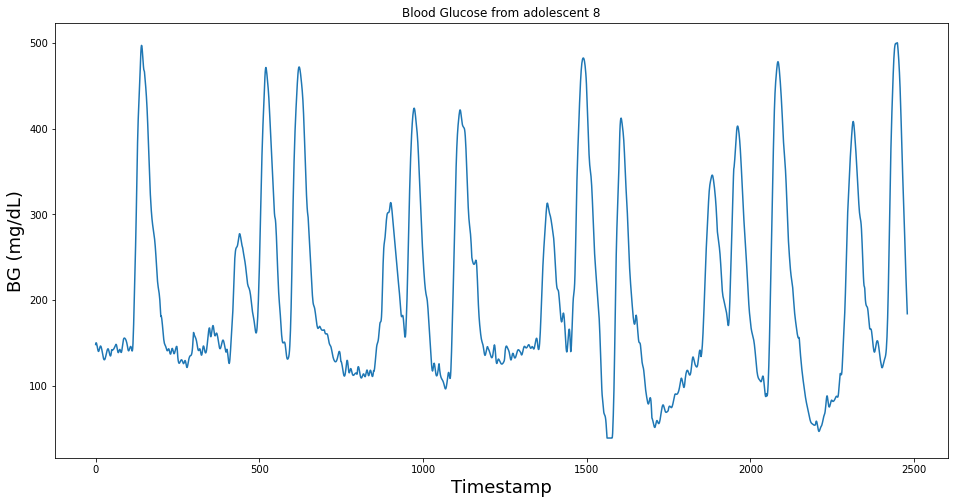

In [47]:
plt.figure(figsize=(16,8))
plt.title('Blood Glucose from adolescent 8')
plt.plot(df['CGM'])
plt.xlabel('Timestamp',fontsize=18)
plt.ylabel('BG (mg/dL)',fontsize=18)
plt.show()

Let's create a function to prepare date for training and testing.

We can take 20 as the length of the input because that is approximately the maximum time which carbs and insulin affects the blood glucose.

In [48]:
def read_pacient(age="adolescent#0", number="08", extension=".csv", training_test_proportion=0.8,input_len=20, output_len=6):

  # reading the file
  df = pd.read_csv(age+number+extension)
  df.Time = pd.to_datetime(df.Time)
  df = df[0:2480] # this final data from some of pacients are not relevant(stays at hipo for to long to be real)
  df.set_index("Time")

  # Getting only blood glucuse from sensor data
  data = df.filter(['CGM'])
  dataset = data.values

  training_data_len = math.ceil( len(dataset) *training_test_proportion) # setting proportion for training and testing

  # Scalling data from 0 - 1 to input in the neural network
  scaler = MinMaxScaler(feature_range=(0, 1)) 
  scaled_data = scaler.fit_transform(dataset)

  train_data = scaled_data[0:training_data_len  , : ] 

  x_train=[] # arrays of blood glucose with len of input_len
  y_train = [] # arrays of blood glucose with len of output_len
  for i in range(input_len,len(train_data)-output_len):
      x_train.append(train_data[i-input_len:i,0]) # past blood glucose to learn
      y_train.append(train_data[i:i+output_len,0]) # future blood glucose to predict

  x_train, y_train = np.array(x_train), np.array(y_train) # converting to numpy array
  '''
  Reshape is necessary so the neural network can understand the data
  Shape will be (number of predictions, input_len, number of features)
  Feature is which property we are using in the model, so in this case it is only the blood glucose from the pacient
  '''
  x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 

  not_scaled_test_data = dataset[training_data_len - input_len: , : ]
  test_data = scaled_data[training_data_len - input_len: , : ]

  x_test = [] # arrays of blood glucose with len of input_len
  y_test = [] # arrays of blood glucose with len of output_len
  continuous_ytest = [] # list with not scaled blood glucose from y_test not broken into arrays

  '''
  So here in the looping of the test we are predicting output_len values
  then the next output_len values so we can create a continuos plot of the 
  predicted glucose
  '''
  i = input_len
  while (i >= input_len and i < len(test_data)-output_len):
    x_test.append(test_data[i-input_len:i,0])
    y_test.append(not_scaled_test_data[i:i+output_len,0])
    for bg in not_scaled_test_data[i:i+output_len,0]:
      continuous_ytest.append(bg) # not for testing, just for plot purpose
    i = i+output_len # jump output_len values in the future

  x_test = np.array(x_test) # converting to numpy array
  x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

  return scaler, x_train, y_train, x_test, y_test, continuous_ytest

Now, let's create a function that applies a LSTM Model to our data

In [64]:
def make_predictions(scaler, x_train, y_train, x_test, y_test, batch_size=1, epochs=1):

  # LSTM Model
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
  model.add(LSTM(units=50, return_sequences=False))
  model.add(Dropout(0.5))
  model.add(Dense(units=y_train.shape[1]))

  model.compile(optimizer="adam", loss='mse',metrics=['accuracy'])
  model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

  predictions = model.predict(x_test) # make predictions
  predictions = np.reshape(predictions, (predictions.shape[0],predictions.shape[1])) # reshape just like y_test

  predictions = scaler.inverse_transform(predictions) # reverse data

  # Create a continuous data of predictions to plot with continuous_ytest
  continuous_predictions = predictions[0]
  for i in range(1,len(predictions)):
    continuous_predictions = np.concatenate([continuous_predictions,predictions[i]])

  rmse=np.sqrt(np.mean(((predictions-y_test)**2)))

  return model, predictions, continuous_predictions, rmse

Finally, we can have a function to plot our results

In [65]:
def show_plots(continuous_ytest, continuous_predictions):
  plt.figure(figsize=(16,8))
  plt.title('Blood Glucose Prediction Model Result')
  plt.plot(continuous_ytest, color = 'b')
  plt.plot(continuous_predictions, color = 'r')
  plt.xlabel('Timestamp',fontsize=18)
  plt.ylabel('BGBG (mg/dL)',fontsize=18)
  plt.legend(['Real','Predictions'], loc='lower right')
  plt.show()

Now just testing!


In [66]:
scaler, x_train, y_train, x_test, y_test, continuous_ytest = read_pacient() # standard parameters are for pacient number 8

In [67]:
model, predictions, continuous_predictions, rmse = make_predictions(scaler, x_train, y_train, x_test, y_test,batch_size=100, epochs=100)

Epoch 1/100
20/20 [==============================] - 1s 30ms/step - loss: 0.0817 - accuracy: 0.2477
Epoch 2/100
20/20 [==============================] - 1s 30ms/step - loss: 0.0300 - accuracy: 0.1568
Epoch 3/100
20/20 [==============================] - 1s 30ms/step - loss: 0.0239 - accuracy: 0.1834
Epoch 4/100
20/20 [==============================] - 1s 31ms/step - loss: 0.0191 - accuracy: 0.1823
Epoch 5/100
20/20 [==============================] - 1s 29ms/step - loss: 0.0153 - accuracy: 0.1900
Epoch 6/100
20/20 [==============================] - 1s 29ms/step - loss: 0.0130 - accuracy: 0.1941
Epoch 7/100
20/20 [==============================] - 1s 30ms/step - loss: 0.0117 - accuracy: 0.2084
Epoch 8/100
20/20 [==============================] - 1s 29ms/step - loss: 0.0117 - accuracy: 0.1890
Epoch 9/100
20/20 [==============================] - 1s 29ms/step - loss: 0.0107 - accuracy: 0.1813
Epoch 10/100
20/20 [==============================] - 1s 29ms/step - loss: 0.0102 - accuracy: 0.1736

##  Results of training with patient number 08


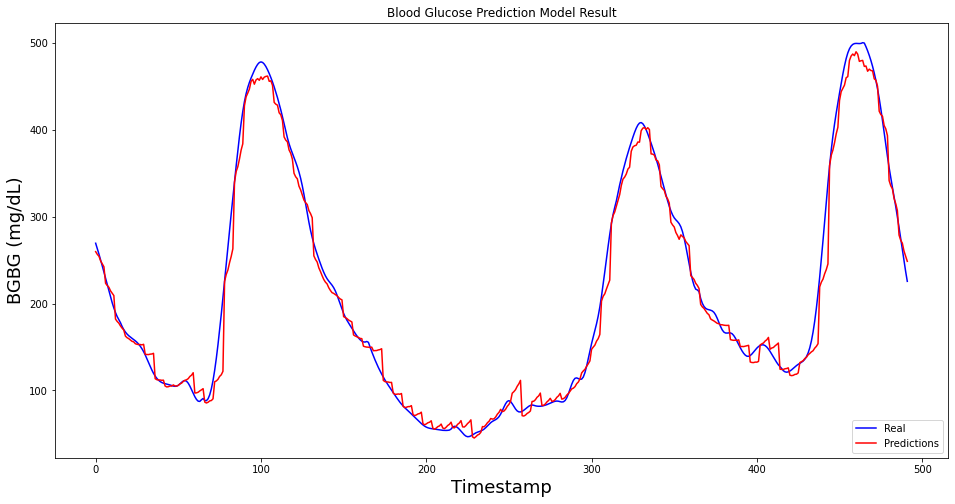

In [68]:
show_plots(continuous_ytest, continuous_predictions)

In [69]:
print("Root-Mean-Squared Deviation {}".format(rmse))

Root-Mean-Squared Deviation 15.099504779068717


We can now create and use a functions to apply this model in other pacient

In [54]:
def test_model(model, age="adolescent#0", number="01", extension=".csv",input_len=20, output_len=6):

  # reading the file
  df = pd.read_csv(age+number+extension)
  df.Time = pd.to_datetime(df.Time)
  df = df[0:2480] # this final data from some of pacients are not relevant(stays at hipo for to long to be real)
  df.set_index("Time")

  # Getting only blood glucuse from sensor data
  data = df.filter(['CGM'])
  dataset = data.values

  # Scalling data from 0 - 1 to input in the neural network
  scaler = MinMaxScaler(feature_range=(0, 1)) 
  scaled_data = scaler.fit_transform(dataset)

  x_test = [] # arrays of blood glucose with len of input_len
  y_test = [] # arrays of blood glucose with len of output_len
  continuous_ytest = [] # list with not scaled blood glucose from y_test not broken into arrays

  i = input_len
  while (i >= input_len and i < len(dataset)-output_len):
    x_test.append(scaled_data[i-input_len:i,0])
    y_test.append(dataset[i:i+output_len,0])
    for bg in dataset[i:i+output_len,0]:
      continuous_ytest.append(bg) # not for testing, just for plot purpose
    i = i+output_len # jump output_len values in the future

  x_test = np.array(x_test) # converting to numpy array
  x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

  predictions = model.predict(x_test) # make predictions
  predictions = np.reshape(predictions, (predictions.shape[0],predictions.shape[1])) # reshape just like y_test

  predictions = scaler.inverse_transform(predictions) # reverse data

  # Create a continuous data of predictions to plot with continuous_ytest
  continuous_predictions = predictions[0]
  for i in range(1,len(predictions)):
    continuous_predictions = np.concatenate([continuous_predictions,predictions[i]])

  rmse=np.sqrt(np.mean(((predictions-y_test)**2)))


  return rmse, continuous_ytest, continuous_predictions



In [55]:
rmse2, continuous_ytes2, continuous_predictions2 = test_model(model)

### Results with Patient number 01

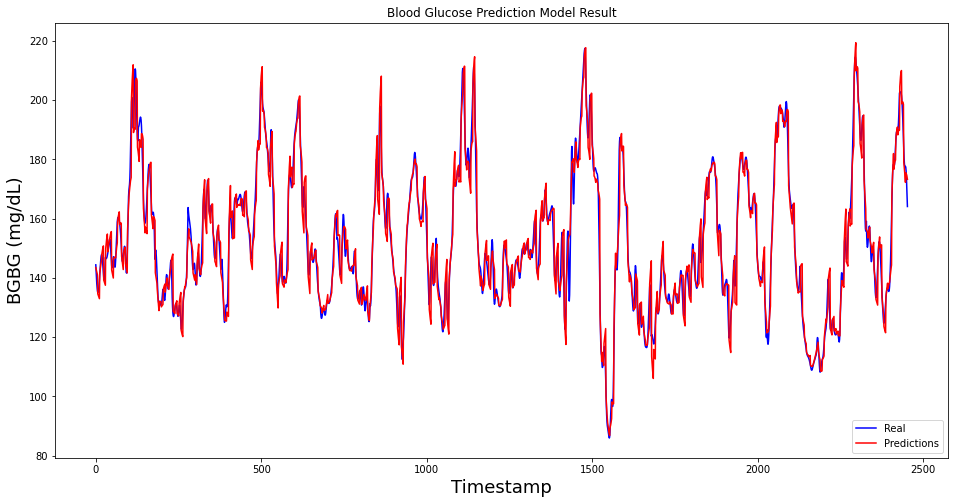

In [56]:
show_plots(continuous_ytes2, continuous_predictions2)

In [57]:
print("Root-Mean-Squared Deviation {}".format(rmse2))

Root-Mean-Squared Deviation 5.146714617474139


In [58]:
rmse3, continuous_predictions3, continuous_ytes3 = test_model(model,number="10")

### Results with Patient number 10

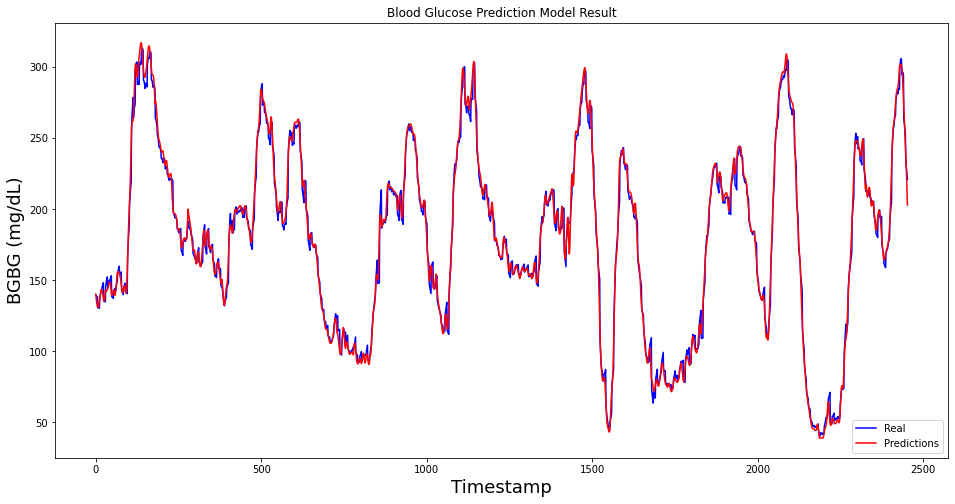

In [59]:
show_plots(continuous_ytes3, continuous_predictions3)

In [60]:
print("Root-Mean-Squared Deviation {}".format(rmse3))

Root-Mean-Squared Deviation 5.821730305709615


In [75]:
rmse4, continuous_predictions4, continuous_ytes4 = test_model(model,number="07")

### Results with Patient number 07

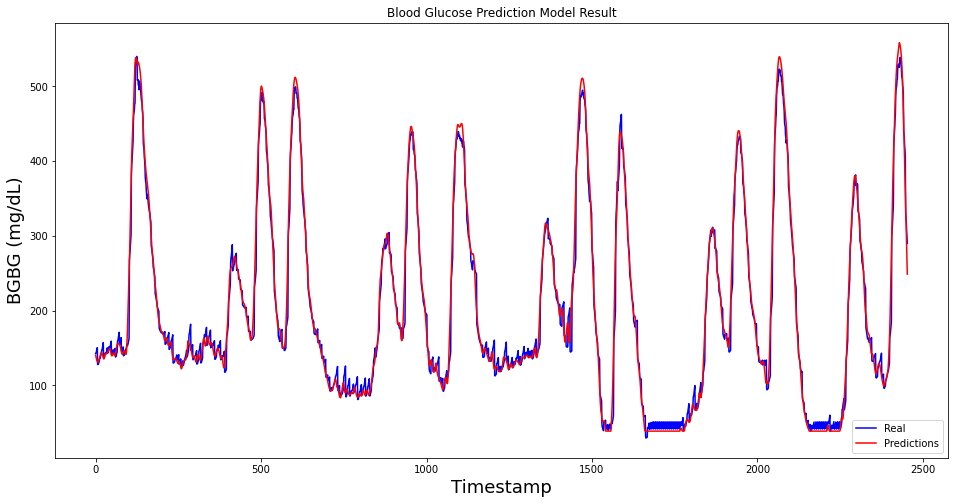

Root-Mean-Squared Deviation 15.60273270768831


In [76]:
show_plots(continuous_ytes4, continuous_predictions4)
print("Root-Mean-Squared Deviation {}".format(rmse4))